In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [3]:
from functions_v2 import(import_folder_dataset,
                         Data,
                         calculate_IoU,
                         plot_loss_accuracy, 
                         save_model,
                         save_metrics,
                         make_predictions)

# 1. Build an image segmentation model using pytorch

In [4]:
# Learning parameters.
epochs = 50 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

checkpoints_save = 25 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
        #################################
        ############ Encoder ############
        #################################
        
        '''
        In dimension:              1024 * 1024 * 3 
        Out dimension Conv:        1024 * 1024 * 64
        Out dimension MaxPooling:  512  * 512  * 64
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              512  * 512  * 64
        Out dimension Conv:        512  * 512  * 128
        Out dimension MaxPooling:  256  * 256  * 128
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              256  * 256  * 128
        Out dimension Conv:        256  * 256  * 256
        Out dimension MaxPooling:  128  * 128  * 256
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              128 * 128 * 256
        Out dimension Conv:        128 * 128 * 512
        Out dimension MaxPooling:  64  * 64  * 512
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              64 * 64 * 512
        Out dimension Conv:        64 * 64 * 1024
        Out dimension MaxPooling:  32 * 32 * 1024
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        #################################
        ############ Decoder ############
        #################################
        
        '''
        In dimension:                 32 * 32 * 1024
        Out dimension Conv:           32 * 32 * 512
        Out dimension ConvTranspose:  64 * 64 * 512
        '''
        self.tcnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.convTrans1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        '''
        In dimension:                 64  * 64  * 512
        Out dimension Conv:           64  * 64  * 256
        Out dimension ConvTranspose:  128 * 128 * 256
        '''
        self.tcnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.convTrans2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        '''
        In dimension:                 128 * 128 * 256
        Out dimension Conv:           128 * 128 * 128
        Out dimension ConvTranspose:  256 * 256 * 128
        '''
        self.tcnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.convTrans3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        '''
        In dimension:                 256 * 256 * 128
        Out dimension Conv:           256 * 256 * 64
        Out dimension ConvTranspose:  512 * 512 * 64
        '''
        self.tcnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.convTrans4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        '''
        In dimension:                 512  * 512  * 64
        Out dimension Conv:           512  * 512  * 32
        Out dimension ConvTranspose:  1024 * 1024 * 32
        '''
        self.tcnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convTrans5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        '''
        In dimension:                 1024 * 1024 * 32
        Out dimension Conv:           1024 * 1024 * 2
        '''
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.ReLU()
        )
        
    def forward(self, x): 
        
        #################################
        ############ Encoder ############
        #################################
        #print("Before Cnn1 ",x.shape)
        # Convolution
        x = self.cnn1_model(x)
        #print("Before MaxPool1 ",x.shape)
        # Max pooling
        x = self.maxpool1(x)
        
        #print("Before Cnn2 ",x.shape)
        # Convolution
        x = self.cnn2_model(x)
        #print("Before MaxPool2 ",x.shape)
        # Max pooling
        x = self.maxpool2(x)
        
        #print("Before Cnn3 ",x.shape)
        # Convolution
        x = self.cnn3_model(x)
        #print("Before MaxPool3 ",x.shape)
        # Max pooling
        x = self.maxpool3(x)
        
        #print("Before Cnn4 ",x.shape)
        # Convolution
        x = self.cnn4_model(x)
        #print("Before MaxPool4 ",x.shape)
        # Max pooling
        x = self.maxpool4(x)
        
        # Convolution
        x = self.cnn5_model(x)
        # Max pooling
        x = self.maxpool5(x)
        
        #################################
        ############ Decoder ############
        #################################
        
        # Convolution
        x = self.tcnn1_model(x)
        # Transopose Convolution
        x = self.convTrans1(x)
        
        #print("Before TCnn2 ",x.shape)
        # Convolution
        x = self.tcnn2_model(x)
        #print("Before ConvTransl2 ",x.shape)
        # Transopose Convolution
        x = self.convTrans2(x)
        
        #print("Before TCnn3 ",x.shape)
        # Convolution
        x = self.tcnn3_model(x)
        #print("Before ConvTransl3 ",x.shape)
        # Transopose Convolution
        x = self.convTrans3(x)
        
        #print("Before TCnn4 ",x.shape)
        # Convolution
        x = self.tcnn4_model(x)
        #print("Before ConvTransl4 ",x.shape)
        # Transopose Convolution
        x = self.convTrans4(x)
        
        #print("Before TCnn5 ",x.shape)
        # Convolution
        x = self.tcnn5_model(x)
        #print("Before ConvTransl5 ",x.shape)
        # Transopose Convolution
        x = self.convTrans5(x)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        #print("Before Segmentation ",x.shape)
        # Convolution Segmentation
        x = self.segmentation(x)
        #print("After Segmentation ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = SegmentationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")

# Loss function.
#criterion = nn.BCEWithLogitsLoss() # Set the loss function to BCEWithLogitsLoss
criterion = nn.CrossEntropyLoss()


parameters = filter(lambda p: p.requires_grad, modelpy.parameters())
optim = torch.optim.Adam(parameters, lr=lr)
#optim = torch.optim.SGD(params=parameters, lr=lr, momentum=0.9, weight_decay=1e-5)# , momentum=0.9, weight_decay=0.0005


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0

modelpy

model created


SegmentationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): S

In [7]:
# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion  = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")



In [8]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 31429006


## Load data

In [9]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Test"

img_size = (256, 256) # (1024, 1024)

In [10]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    #transforms.Resize((1024, 1024)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
train_data, train_mask, train_labels = import_folder_dataset(root_path = train_data_path, resized_side = img_size)#(1024,1024)

print("Dim of Data: ", train_data.shape)
print("Dim of Mask: ", train_mask.shape)
print("Dim of Lables: ", train_labels.shape)

100%|██████████| 800/800 [00:19<00:00, 40.04it/s]


Dim of Data:  (800, 256, 256, 3)
Dim of Mask:  (800, 256, 256, 3)
Dim of Lables:  (800, 256, 256)


In [12]:
# Split into Train, Validation
X_train, X_val, m_train, m_val, y_train, y_val = train_test_split(train_data, train_mask, train_labels, test_size=0.1, random_state=42)
print("Dim of Image Train: ", X_train.shape)
print("Dim of Mask Train: ", m_train.shape)
print("Dim of Lables Train: ", y_train.shape)


print("Dim of Image Validation: ", X_val.shape)
print("Dim of Mask Validation: ", m_val.shape)
print("Dim of Lables Validation: ", y_val.shape)

Dim of Image Train:  (720, 256, 256, 3)
Dim of Mask Train:  (720, 256, 256, 3)
Dim of Lables Train:  (720, 256, 256)
Dim of Image Validation:  (80, 256, 256, 3)
Dim of Mask Validation:  (80, 256, 256, 3)
Dim of Lables Validation:  (80, 256, 256)


In [13]:
# Create the dataset object
train_Dataset = Data(X_train, m_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, m_val, y_val, img_transform)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  720
Val len:  80


In [14]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)


Epoch 1 of 50


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


train loss:  0.12279896405008105
Val loss:  0.10547886304557323
train IoU:  0.45152016601835687
Val IoU:  0.5784166008234024
Current time: 1.577 minutes. Time expected till completion: 77.290 minutes

Epoch 2 of 50


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


train loss:  0.10162232261564996
Val loss:  0.09799021519720555
train IoU:  0.5926637053489685
Val IoU:  0.6151233553886414
Current time: 3.089 minutes. Time expected till completion: 74.148 minutes

Epoch 3 of 50


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


train loss:  0.0973723490205076
Val loss:  0.09530342854559422
train IoU:  0.6115255494912465
Val IoU:  0.6447935074567794
Current time: 4.602 minutes. Time expected till completion: 72.097 minutes

Epoch 4 of 50


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


train loss:  0.04416479594591591
Val loss:  0.03516140822321177
train IoU:  0.8050674302710428
Val IoU:  0.8239422053098678
Current time: 6.115 minutes. Time expected till completion: 70.317 minutes

Epoch 5 of 50


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


train loss:  0.034338817466050386
Val loss:  0.04833556730300188
train IoU:  0.8187685638666153
Val IoU:  0.7843990474939346
Current time: 7.623 minutes. Time expected till completion: 68.605 minutes

Epoch 6 of 50


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


train loss:  0.0304020243903829
Val loss:  0.033238609600812194
train IoU:  0.8368993987639745
Val IoU:  0.8313255488872529
Current time: 9.135 minutes. Time expected till completion: 66.989 minutes

Epoch 7 of 50


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


train loss:  0.028221910032961102
Val loss:  0.03220822671428323
train IoU:  0.8479060192902883
Val IoU:  0.8399792850017548
Current time: 10.648 minutes. Time expected till completion: 65.408 minutes

Epoch 8 of 50


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


train loss:  0.026057365464253558
Val loss:  0.028028400056064127
train IoU:  0.8581413166390525
Val IoU:  0.8573162436485291
Current time: 12.157 minutes. Time expected till completion: 63.825 minutes

Epoch 9 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.02479682152883874
Val loss:  0.028334387019276618
train IoU:  0.8648624916871389
Val IoU:  0.8594881862401962
Current time: 13.671 minutes. Time expected till completion: 62.278 minutes

Epoch 10 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.023635498848226334
Val loss:  0.028868580237030983
train IoU:  0.8693559474415249
Val IoU:  0.853888776898384
Current time: 15.181 minutes. Time expected till completion: 60.722 minutes

Epoch 11 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.022832595536278352
Val loss:  0.02745745787397027
train IoU:  0.8725979798369937
Val IoU:  0.8585460364818573
Current time: 16.694 minutes. Time expected till completion: 59.188 minutes

Epoch 12 of 50


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


train loss:  0.021998658683151005
Val loss:  0.028811413422226907
train IoU:  0.877609834406111
Val IoU:  0.8532278716564179
Current time: 18.205 minutes. Time expected till completion: 57.648 minutes

Epoch 13 of 50


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


train loss:  0.020260304538533093
Val loss:  0.027098899893462657
train IoU:  0.8868985440995958
Val IoU:  0.8646022737026214
Current time: 19.715 minutes. Time expected till completion: 56.112 minutes

Epoch 14 of 50


100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


train loss:  0.019544338072753614
Val loss:  0.02714642370119691
train IoU:  0.890559795498848
Val IoU:  0.8691321045160294
Current time: 21.228 minutes. Time expected till completion: 54.586 minutes

Epoch 15 of 50


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


train loss:  0.018591529694903228
Val loss:  0.02685624184086919
train IoU:  0.8947861426406436
Val IoU:  0.8635111421346664
Current time: 22.738 minutes. Time expected till completion: 53.055 minutes

Epoch 16 of 50


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


train loss:  0.01701791084681948
Val loss:  0.02730862218886614
train IoU:  0.9035274581776724
Val IoU:  0.8688069432973862
Current time: 24.249 minutes. Time expected till completion: 51.530 minutes

Epoch 17 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.016720876397771967
Val loss:  0.027790137100964785
train IoU:  0.9052107804351383
Val IoU:  0.867720040678978
Current time: 25.758 minutes. Time expected till completion: 50.002 minutes

Epoch 18 of 50


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


train loss:  0.015783383743837476
Val loss:  0.02749347323551774
train IoU:  0.9097589608695772
Val IoU:  0.868513947725296
Current time: 27.265 minutes. Time expected till completion: 48.472 minutes

Epoch 19 of 50


100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


train loss:  0.01485363121351434
Val loss:  0.0285356177482754
train IoU:  0.9150282171037462
Val IoU:  0.8623326659202576
Current time: 28.782 minutes. Time expected till completion: 46.960 minutes

Epoch 20 of 50


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


train loss:  0.014483475395374827
Val loss:  0.02919703098013997
train IoU:  0.9163285755448871
Val IoU:  0.8661975651979447
Current time: 30.306 minutes. Time expected till completion: 45.459 minutes

Epoch 21 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.013585800579231646
Val loss:  0.02828505290672183
train IoU:  0.9215944657723109
Val IoU:  0.872076490521431
Current time: 31.826 minutes. Time expected till completion: 43.950 minutes

Epoch 22 of 50


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


train loss:  0.012775451726176673
Val loss:  0.030436698999255895
train IoU:  0.9264682044585546
Val IoU:  0.8654840290546417
Current time: 33.363 minutes. Time expected till completion: 42.462 minutes

Epoch 23 of 50


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


train loss:  0.01210340299229655
Val loss:  0.030743909627199174
train IoU:  0.930161373813947
Val IoU:  0.870739808678627
Current time: 34.930 minutes. Time expected till completion: 41.005 minutes

Epoch 24 of 50


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


train loss:  0.012201144644576643
Val loss:  0.03252304708585143
train IoU:  0.9296121418476104
Val IoU:  0.8679209083318711
Current time: 36.494 minutes. Time expected till completion: 39.535 minutes

Epoch 25 of 50


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


train loss:  0.011568234281407462
Val loss:  0.031852019112557174
train IoU:  0.932770441306962
Val IoU:  0.8701374858617783
Saving model checkpoint


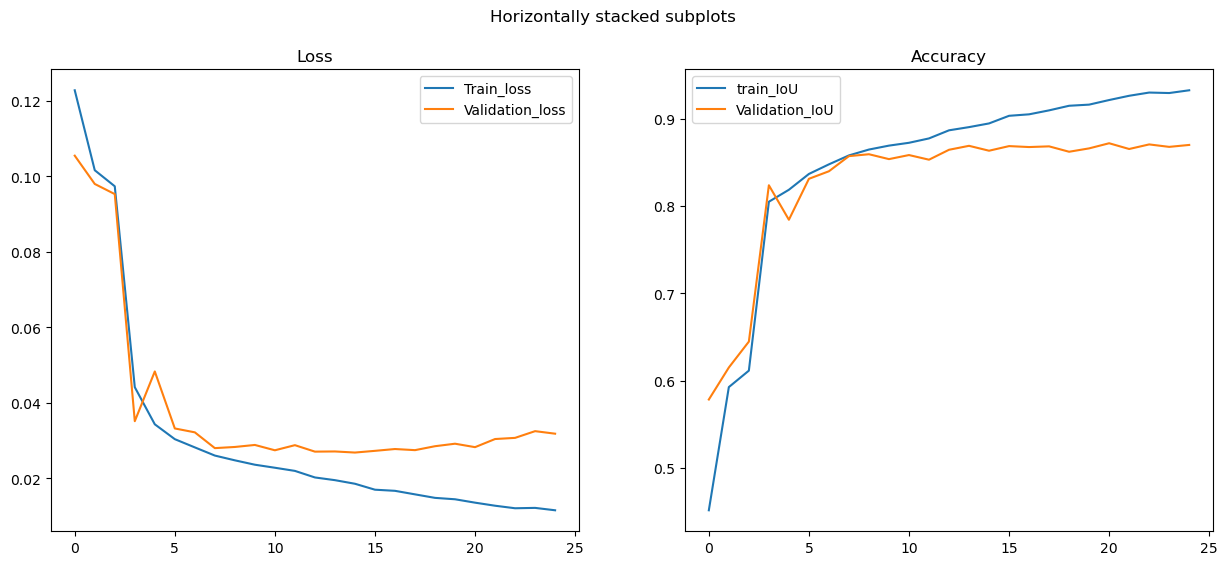

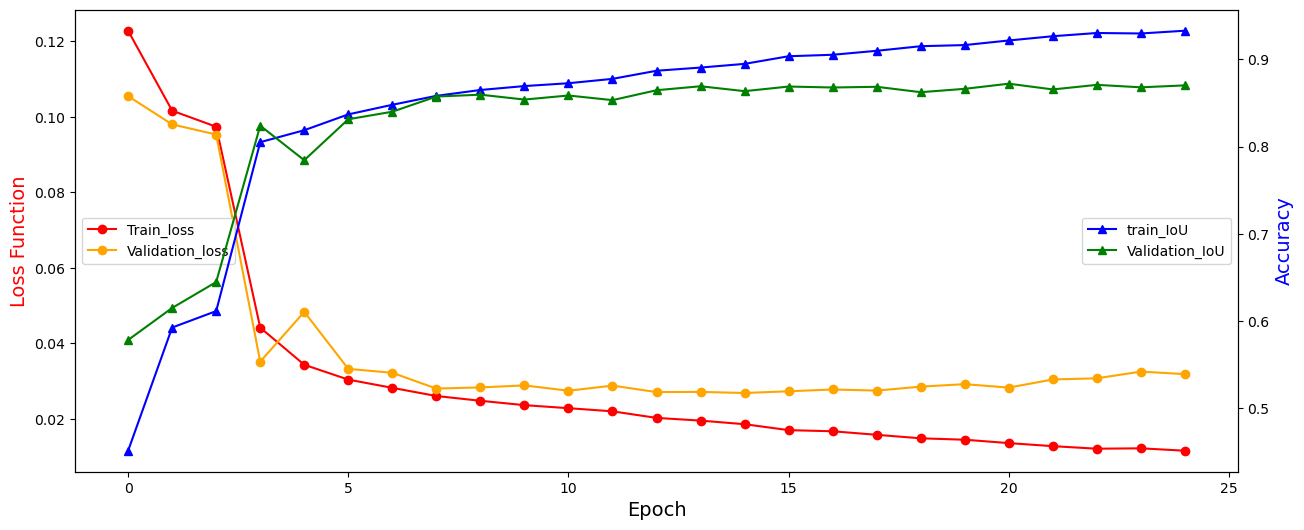

Current time: 38.282 minutes. Time expected till completion: 38.282 minutes

Epoch 26 of 50


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


train loss:  0.010904403020524317
Val loss:  0.035438671708106995
train IoU:  0.9368632667594485
Val IoU:  0.8614351958036423
Current time: 39.793 minutes. Time expected till completion: 36.732 minutes

Epoch 27 of 50


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


train loss:  0.010722758289840486
Val loss:  0.03267444968223572
train IoU:  0.9376779625813166
Val IoU:  0.8722299605607986
Current time: 41.333 minutes. Time expected till completion: 35.210 minutes

Epoch 28 of 50


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


train loss:  0.010228730528615415
Val loss:  0.03283022828400135
train IoU:  0.9404995050695207
Val IoU:  0.8714143425226212
Current time: 42.890 minutes. Time expected till completion: 33.700 minutes

Epoch 29 of 50


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


train loss:  0.009449018669935564
Val loss:  0.03458309192210436
train IoU:  0.944897269209226
Val IoU:  0.8674607843160629
Current time: 44.456 minutes. Time expected till completion: 32.192 minutes

Epoch 30 of 50


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


train loss:  0.00953489798379855
Val loss:  0.034616816136986014
train IoU:  0.9441601014799542
Val IoU:  0.8715518593788147
Current time: 46.020 minutes. Time expected till completion: 30.680 minutes

Epoch 31 of 50


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


train loss:  0.008943734183493588
Val loss:  0.03577046971768141
train IoU:  0.9479778074555927
Val IoU:  0.871882751584053
Current time: 47.593 minutes. Time expected till completion: 29.170 minutes

Epoch 32 of 50


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


train loss:  0.008908244946764576
Val loss:  0.03585612680763006
train IoU:  0.9477659510241614
Val IoU:  0.8710356742143631
Current time: 49.164 minutes. Time expected till completion: 27.655 minutes

Epoch 33 of 50


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


train loss:  0.00840212477164136
Val loss:  0.03542146403342485
train IoU:  0.9508346067534552
Val IoU:  0.8745420187711715
Current time: 50.746 minutes. Time expected till completion: 26.142 minutes

Epoch 34 of 50


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


train loss:  0.008339038793928921
Val loss:  0.03431683331727982
train IoU:  0.9512130634652244
Val IoU:  0.8741384357213974
Current time: 52.310 minutes. Time expected till completion: 24.616 minutes

Epoch 35 of 50


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


train loss:  0.008184986269204981
Val loss:  0.03627361813560128
train IoU:  0.9520543472634422
Val IoU:  0.8737425953149796
Current time: 53.863 minutes. Time expected till completion: 23.084 minutes

Epoch 36 of 50


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


train loss:  0.008173352296257184
Val loss:  0.03498111302033067
train IoU:  0.9518791112634871
Val IoU:  0.8715154439210892
Current time: 55.425 minutes. Time expected till completion: 21.554 minutes

Epoch 37 of 50


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


train loss:  0.007892899067761997
Val loss:  0.03597478326410055
train IoU:  0.953481391734547
Val IoU:  0.8741890966892243
Current time: 56.970 minutes. Time expected till completion: 20.016 minutes

Epoch 38 of 50


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


train loss:  0.00782712565528022
Val loss:  0.03580497205257416
train IoU:  0.9539280600017972
Val IoU:  0.8732961237430572
Current time: 58.514 minutes. Time expected till completion: 18.478 minutes

Epoch 39 of 50


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


train loss:  0.0077067118991787234
Val loss:  0.0375276786275208
train IoU:  0.9547842592000961
Val IoU:  0.8733557313680649
Current time: 60.093 minutes. Time expected till completion: 16.949 minutes

Epoch 40 of 50


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


train loss:  0.00737457435267667
Val loss:  0.03712935606017709
train IoU:  0.9566063698795106
Val IoU:  0.8759069681167603
Current time: 61.670 minutes. Time expected till completion: 15.417 minutes

Epoch 41 of 50


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


train loss:  0.007162085806743966
Val loss:  0.03810119414702058
train IoU:  0.9575036810504065
Val IoU:  0.873107773065567
Current time: 63.254 minutes. Time expected till completion: 13.885 minutes

Epoch 42 of 50


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


train loss:  0.006981496644827227
Val loss:  0.03807551665231586
train IoU:  0.959099006652832
Val IoU:  0.8767804086208344
Current time: 64.840 minutes. Time expected till completion: 12.350 minutes

Epoch 43 of 50


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


train loss:  0.006910245376639068
Val loss:  0.04048469280824065
train IoU:  0.9591308921575546
Val IoU:  0.8753613233566284
Current time: 66.426 minutes. Time expected till completion: 10.814 minutes

Epoch 44 of 50


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


train loss:  0.006933806076024969
Val loss:  0.038648470770567656
train IoU:  0.9589888009760115
Val IoU:  0.8752477139234542
Current time: 68.009 minutes. Time expected till completion: 9.274 minutes

Epoch 45 of 50


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


train loss:  0.0069958831131872205
Val loss:  0.03662739293649793
train IoU:  0.9587651732895109
Val IoU:  0.876254090666771
Current time: 69.589 minutes. Time expected till completion: 7.732 minutes

Epoch 46 of 50


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


train loss:  0.00674596397827069
Val loss:  0.03954526856541633
train IoU:  0.9602563185824289
Val IoU:  0.8746210187673569
Current time: 71.176 minutes. Time expected till completion: 6.189 minutes

Epoch 47 of 50


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


train loss:  0.0064087112977479896
Val loss:  0.03988430378958583
train IoU:  0.9620891256464852
Val IoU:  0.8770294845104217
Current time: 72.759 minutes. Time expected till completion: 4.644 minutes

Epoch 48 of 50


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


train loss:  0.006347128945506281
Val loss:  0.040514726750552656
train IoU:  0.9625543587737613
Val IoU:  0.877106922864914
Current time: 74.317 minutes. Time expected till completion: 3.097 minutes

Epoch 49 of 50


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


train loss:  0.006540239048707816
Val loss:  0.03738718284294009
train IoU:  0.9614960342645645
Val IoU:  0.8782507687807083
Current time: 75.836 minutes. Time expected till completion: 1.548 minutes

Epoch 50 of 50


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


train loss:  0.006312409770261082
Val loss:  0.04039622973650694
train IoU:  0.9628575911124547
Val IoU:  0.8780524760484696
Saving model checkpoint


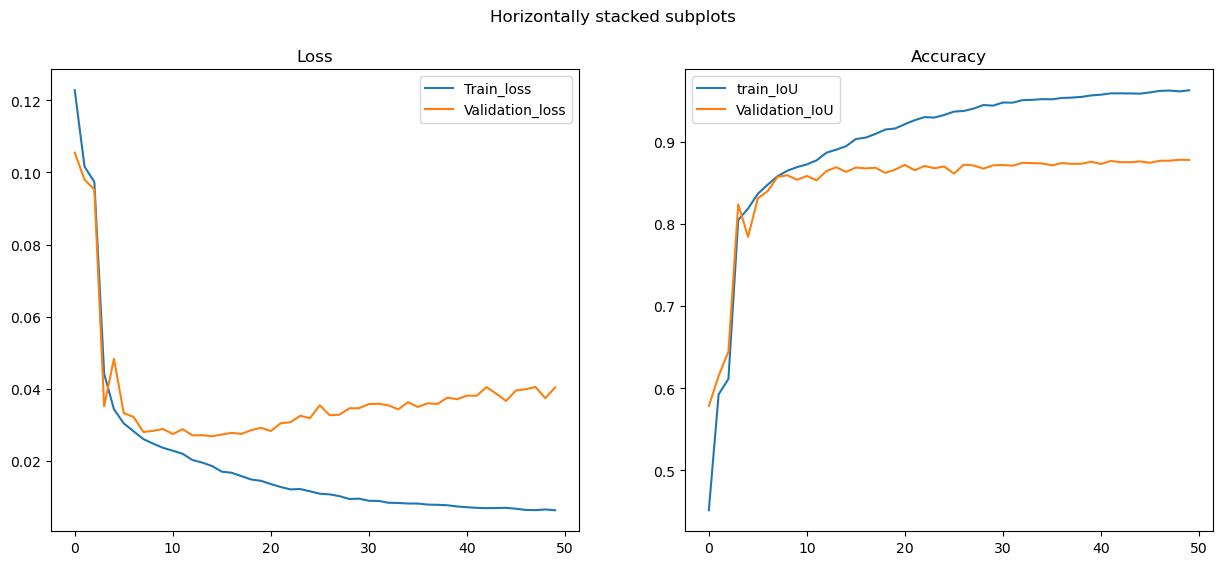

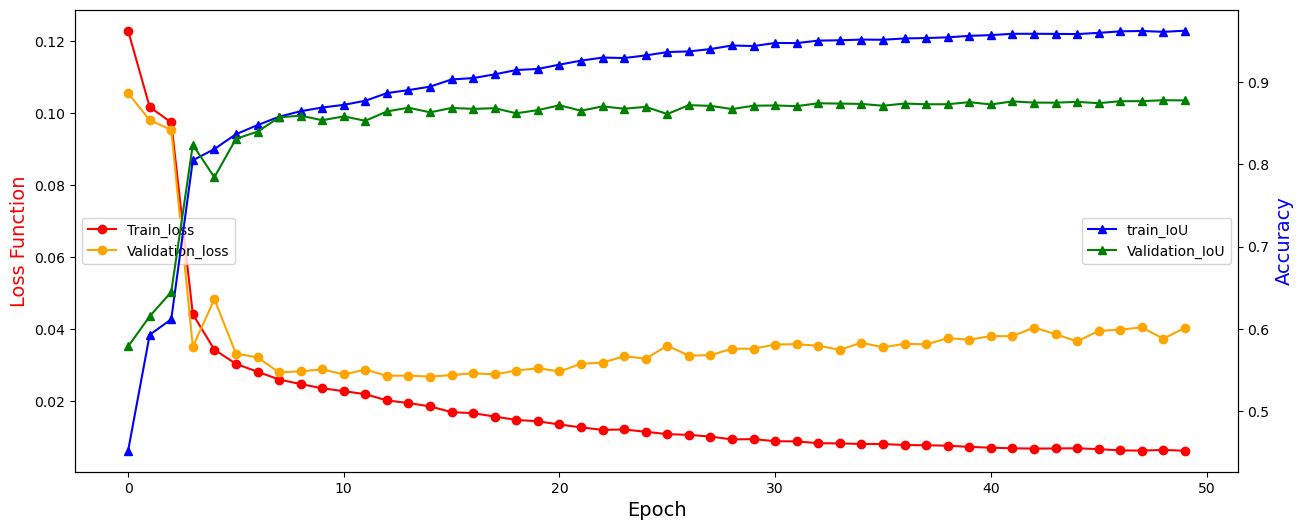

Current time: 77.523 minutes. Time expected till completion: 0.000 minutes
Finished training in: 77.525 minutes


In [15]:

# Main
train_loss, val_loss = [], []
train_IoU, val_IoU = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_IoU = dd["train_IoU"].tolist()
        val_IoU = dd["val_IoU"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    accumulatedIoU=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[2].to(device)# use the gpu
        
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate IoU
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        
        iioouu = calculate_IoU(predictions, labels)
        accumulatedIoU += iioouu.sum().item()
    
    train_epoch_loss = running_loss/len(train_loader.dataset)
    train_epoch_IoU = accumulatedIoU/total
    
    
    modelpy.eval()
    running_loss = 0.0
    total=0
    accumulatedIoU=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            labels = data[2].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, labels)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iioouu = calculate_IoU(predictions, labels)
            accumulatedIoU += iioouu.sum().item()
           
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_IoU = accumulatedIoU/total

    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train IoU: ", train_epoch_IoU)
    print("Val IoU: ", val_epoch_IoU)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_IoU.append(train_epoch_IoU)
    val_IoU.append(val_epoch_IoU)
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_IoU, val_IoU, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

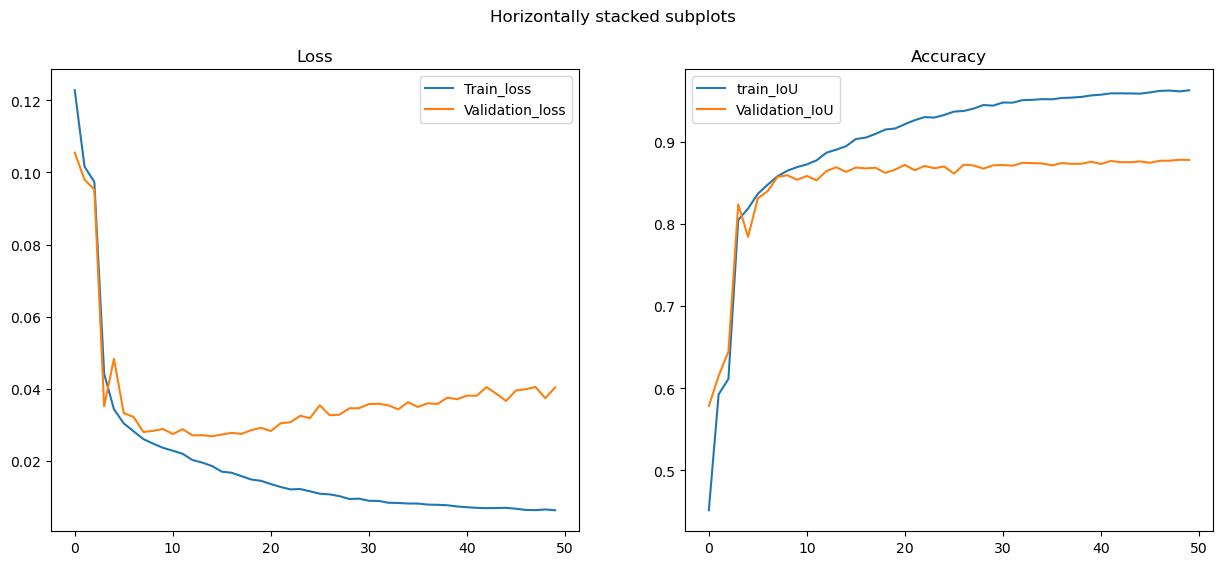

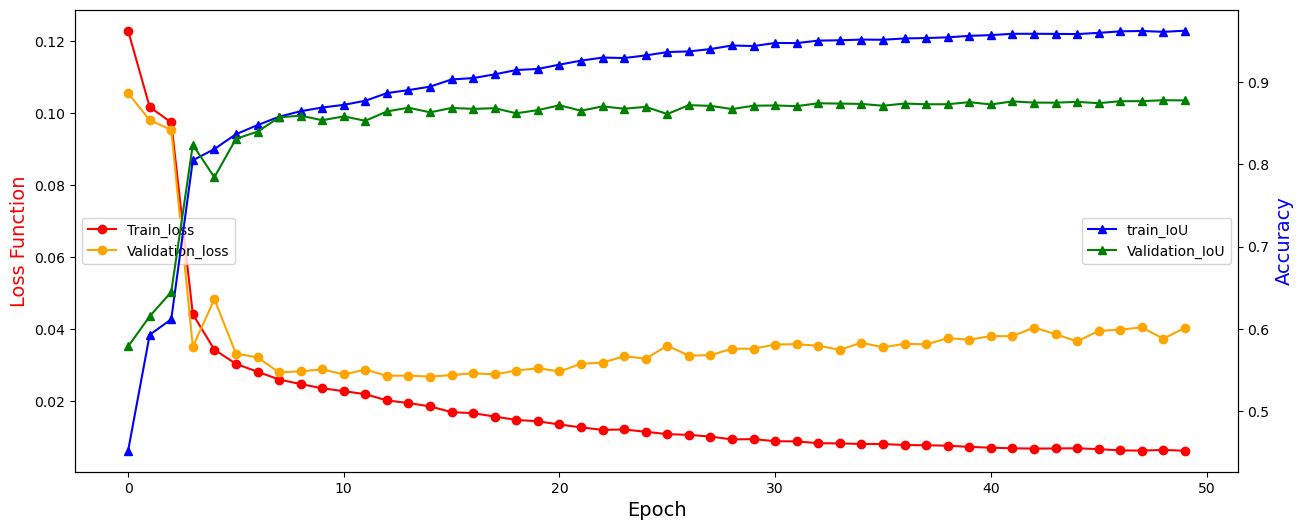

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)

## Save Model

In [17]:
# Save Model
NAME = "model_1.pt"

torch.save(modelpy.state_dict(), model_checkpoints+NAME)

## Load Model

In [18]:

# Load the model
NAME = "model_1.pt"
modelpy.load_state_dict(torch.load(model_checkpoints+NAME, map_location=device))


<All keys matched successfully>

# 3.Evaluate your model using the test images

In [19]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [20]:
test_data, test_mask, test_labels = import_folder_dataset(root_path = test_data_path, resized_side = img_size)#(1024,1024)


print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)

100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)


In [21]:
# Create the dataset object
test_Dataset = Data(test_data, test_mask, test_labels, img_transform) 


print("Test len: ",len(test_Dataset))

Test len:  200


In [22]:
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,
    shuffle=False
    )

In [23]:

mean_IoU, mean_dice, image_list, mask_list, predictions_list = make_predictions(loader = test_loader, 
                                                                     model = modelpy, 
                                                                     invTransforamtion = invTrans,
                                                                     device = device)
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


Average IoU of the model on the 200 Test dataset instances: 89.0510273873806%
Average Dice of the model on the 200 Test dataset instances: 94.12284916639328%


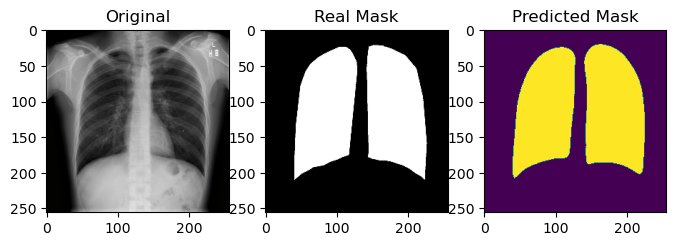

In [24]:
image_to_plot = 10

real_image = image_list[image_to_plot]
real_mask = mask_list[image_to_plot]
pred_mask = predictions_list[image_to_plot]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(8,8))
ax1.imshow(real_image)
ax1.title.set_text("Original")
ax2.imshow(real_mask)
ax2.title.set_text("Real Mask")
ax3.imshow(pred_mask)
ax3.title.set_text("Predicted Mask")
plt.show()

# 4. Your IoU score should be higher than 0.82

In [25]:
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')

Average IoU of the model on the 200 Test dataset instances: 89.0510273873806%


In [26]:
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

Average Dice of the model on the 200 Test dataset instances: 94.12284916639328%


# 5. Write a two-page report using LaTex and upload your paper to ResearchGate or Arxiv. 
